In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 5000

In [2]:
# Data formatted in different notebook
sleep_data = pd.read_csv('sleep_data.csv')
wake_data = pd.read_csv('wake_data.csv')

# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']


In [3]:
sleep_data.head(3)

,Unnamed: 0,indicator,time_offset
0,1/6/2018 21:19,0,-41
1,1/6/2018 21:20,0,-40
2,1/6/2018 21:21,0,-39


In [4]:
wake_data.head(3)

,Unnamed: 0,indicator,time_offset
0,12/1/2017 5:00,1,-60
1,12/1/2017 5:01,1,-59
2,12/1/2017 5:02,1,-58


#### Falling Asleep Data
Each dot represents one observation at a specific time with the color intensity corresponding to the number of points at that time. We can see that I tend to fall asleep a little after 10:00 PM.vEach dot represents one observation at a specific time with the color intensity corresponding to the number of points at that time. We can see that I tend to fall asleep a little after 10:00 PM.

In [5]:
print('Number of sleep observations %d' % len(sleep_data))

Number of sleep observations 4841


In [6]:
print('Number of sleep observations %d' % len(wake_data))

Number of sleep observations 11340


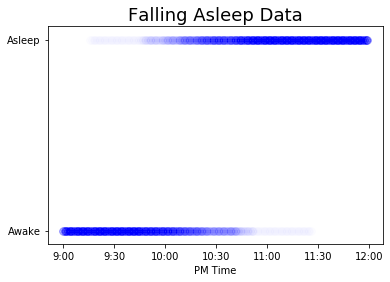

In [7]:
# visualize asleep data
# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); 
plt.title('Falling Asleep Data', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

#### Waking Up Data
My alarm is set for 6:00 AM every day of the week, and the wake data is more consistent than the sleep data. I nearly always wake up within a 10 minute window around 6:00 AM.

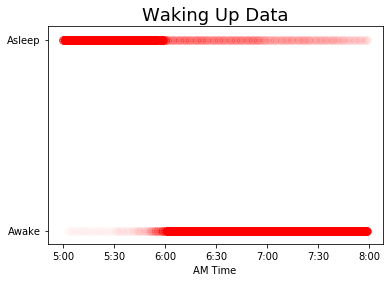

In [8]:
# visualize waking up data
# Sleep data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'r', edgecolors='r')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('AM Time'); 
plt.title('Waking Up Data', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

### PyMC3 Model
We are using a powerful Bayesian Inference library in Python called PyMC3. This library has features for running Markov Chain Monte Carlo and other inference algorithms. This report does not detail PyMC3, but a great book for getting started is Probabilistic Programming and Bayesian Methods for Hackers by Cameron Davidson-Pilon which is available for free on GitHub
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

The following code creates the model and performs MCMC, drawing N_SAMPLES number of samples for $\beta$ and $\alpha$. The specific sampling algorithm is Metropolic Hastings. We feed in the data and tell the model it is observations of the Bernoulli variable. The model then tries to maximize the parameters under the data.

We have no evidence to suggest what the prior distributions for the model parameters $\beta$ and $\alpha$ are ahead of time. Therefore, we can model them as if they came from a normal distribution. The normal, or Gaussian, distribution is defined by the mean, $\mu$, and the precision, $\tau$. The precision is the reciprocal of the standard deviation, $\sigma$. The mean defines the location of the distribution and the precision shows the spread. A larger value of $\tau$ indicates the data is less spread out (it is more precise) and hence the variation is smaller. The mean can be either positive or negative, but the precision will always be positive. A normal distribution as defined here is represented as:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$

Markov Chain Monte Carlo will sample both $\beta$ and $\alpha$ from two normal distributions to find the parameters. Each iteration (state), an estimate for both $\beta$ and $\alpha$ are drawn from the prior. If the parameters increase the probabilty of the data, the state is accepted, but if the parameters are not in agreement with the data, the state is rejected. Monte Carlo refers to the sampling part of the algorithm. Markov Chain means that the next state is only dependent on the current state in a first order process (second order depends on the current and 1 previous step, third order on the current and 2 previous steps and so on). MCMC will return every sample of the parameters for the number of specified steps. This is known as the model trace. To find the most likely parameters, we can take the average of the samples in the trace. MCMC does not given an exact answer, but rather tries to find the maximum likelihood states under the data.

When modeling with MCMC up to 50% of the initial steps, referred to as the burn-in part of the trace, are discarded because the algorithm returns more likely parameters as the number of samples increases. The initial samples are less likely than the latter samples on average. There are a number of methods to test for convergence of MCMC, including visually inspecting the trace, and calculating the auto-correlation of the trace (a lower auto-correlation is an indicator of convergence). We will look at the trace in this example, but will not take rigorous steps to address convergence. There are also a number of methods to choose a smart starting value for the Markov Chain such as Maximum A Posterior estimation. Choosing an intelligent initial value can speed up convergence.


##### Posterior Probability of Sleep given Time
We have all the pieces for the poesterior probabilty and can now put them together. The logistic function describes the transition from awake to asleep, but we do not konw the parameters $\beta$ and $\alpha$. The aim is to find the parameters of the logistic function which maximize the likelihood of the observed data. The parameters are assumed to come from a normal distribution defined by a mean, $\mu$ and a variance, $\tau$. The MCMC algorithm will sample values of $\mu$ and $\tau$ for both $\alpha$ and $\beta$ to try and maximize the parameters of the logistic function given the data.

The data is connected to the parameters through a Bernoulli Variable.

##### Bernoulli Variable
A bernoulli variable is a discrete random variable that is either 0 or 1. In our example, we can model asleep or awake as a Bernoulli variable where awake is 0 and asleep is 1. The Bernoulli variable for sleep depends on the time, in a manner defined by the logistic function.

$$ \text{Sleep Probability, $S_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$
$p(t_i)$ is the logistic function with the independent variable time, so this becomes:

$$ P(\text{sleep} | t_i) = \text{Ber}(\frac{1}{1 + e^{(\beta t_i + \alpha)}})$$
The goal of MCMC is to find the $\alpha$ and $\beta$ parameters using the data and assuming normal priors.


In order to draw random values of alpha and beta, we need to assume a prior distribution for these values. As we have no assumptions about the parameters ahead of time, we can use a normal distribution. The normal, or Gaussian distribution, is defined by the mean, showing the location of the data, and the variance, showing the spread.


The specific MCMC algorithm we are using is called Metropolis Hastings. In order to connect our observed data to the model, every time a set of random values are drawn, the algorithm evaluates them against the data. If they do not agree with the data (I’m simplifying a little here), the values are rejected and the model remains in the current state. If the random values are in agreement with the data, the values are assigned to the parameters and become the current state. This process continues for a specified number of steps, with the accuracy of the model improving with the number of steps.
Putting it all together, the basic procedure for Markov Chain Monte Carlo in our problem is as follows:
Select an initial set of values for alpha and beta, the parameters of the logistic function.
Randomly assign new values to alpha and beta based on the current state.
Check if the new random values agree with the observations. If they do not, reject the values and return to the previous state. If they do, accept the values as the new current state.
Repeat steps 2 and 3 for the specified number of iterations.
The algorithm returns all of the values it generates for alpha and beta. We can then use the average of these values as the most likely final values for alpha and beta in the logistic function. MCMC cannot return the “True” value but rather an approximation for the distribution. The final model for the probability of sleep given the data will be the logistic function with the average values of alpha and beta.

In [9]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

Lets fit a Bayesian linear regression model to this data. As you can see, model specifications in PyMC3 are wrapped in a with statement.

https://docs.pymc.io/notebooks/getting_started all explanations how code works




https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb

good book

In [10]:
#pymc3 model
#pm.Model() - creates a new Model object which is a contrainer for the model random variables
#Following instantiation of the model, the subsequent specification of the model components 
#is performed inside a with statement:

#This creates a context manager, with our sleep_model as the context, that includes
#all statements until the indented block ends(see where ; is). This means all PyMC3 objects 
#introduced in 
#the indented code block below the with statement are added to the model behind the scenes.
#Absent this context manager idiom, we would be forced to manually associate each of the 
#variables with basic_model right after we create them. If you try to create a new random 
#variable without a with model: statement, it will raise an error since there is no obvious
#model for the variable to be added to.


with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    #The first two  statements in the context manager:
    #We call the Normal constructor to create a random variable to use as a normal prior.
    #Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial 
    #and many others, are available in PyMC3.
    #select an initial set of values for alpha and beta, the parameters of the logistic regression
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    #We can create a deterministic variable similarly to how we create a stochastic variable.
    #We simply call up the Deterministic class in PyMC3 and pass in the function that we desire
    ## tt - Teano package similar to Numpy for calculations
    ## see formula above
    
    #2. randomly assign new values to alpha and beta based on the current state
    
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed dat
    #tell the model it is observations of the Bernoiuli variable
    #data is connected throw Bernoulli variable
    
    #3.check if new random values agree with the observations, if the do not, reject
    #the values and return to the previous state
    #if the do, accept the values as the new current state
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling as a sampling algorithm
    
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    
    #repeat steps 2 and 3 for the specified number of iterations
    sleep_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains, 0 divergences: 100%|█| 11000/11000 [00:25<00:00, 426.84draws
The number of effective samples is smaller than 10% for some parameters.


The algorithm returns all of the values it generates for alpha and beta. We can then use the average of these values as the most likely final values for alpha and beta in the logistic function. MCMC cannot return the “True” value but rather an approximation for the distribution. The final model for the probability of sleep given the data will be the logistic function with the average values of alpha and beta.




The trace variable contains all of the samples drawn from the posterior for $\beta$ and $\alpha$. We can graph these samples to explore how they change over the course of sampling. The idea of MCMC is that the samples get more likely given the data as the algorithm continues. In other words, the MCMC algorithm converges on the most likely values as the samples increase. We expect the latter values drawn from the posterior to be more accurate than the earlier values. In Markov Chain Monte Carlo, it is common practice to discard a portion of the samples, usually about 50%, which are known as the burn-in samples. For this report I am not discarding any samples, but in a real application, we would run the model for many more steps and discard the initial samples.


### Visualize Posteriors for $\beta$ and $\alpha$
The values returned in the trace are all the samples drawn for the parameters. We can visually inspect these values in histograms.

In [18]:
#After a backend is finished sampling, it returns a MultiTrace object
#https://docs.pymc.io/api/backends.html
print(sleep_trace)

<MultiTrace: 2 chains, 5000 iterations, 3 variables>


In [11]:

# Extract the alpha and beta samples from multitrace which is output from sampling
alpha_samples = sleep_trace["alpha"][5000:, None]
beta_samples = sleep_trace["beta"][5000:, None]

In [16]:
print(alpha_samples)

[[1.41239012]
 [1.47731866]
 [1.43448816]
 ...
 [1.51077989]
 [1.51077989]
 [1.51077989]]


In [17]:
print(beta_samples)

[[-0.06828949]
 [-0.06828949]
 [-0.06828949]
 ...
 [-0.07340334]
 [-0.07340334]
 [-0.07340334]]


In MCMC, it is common practice to discard up to 90% of the trace. The algorithm does not immediately converge to the true distribution and the initial values are often inaccurate. The later values for the parameters are generally better which means they are what we should use for building our model. We used 10000 samples and discarded the first 50%, but an industry application would likely use hundreds of thousands or millions of samples.
MCMC converges to the true value given enough steps, but assessing convergence can be difficult. I will leave that topic out of this post (one way is by measuring the auto-correlation of the traces) but it is an important consideration if we want the most accurate results. PyMC3 has built in functions for assessing the quality of models, including trace and autocorrelation plots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A01E0A4588>,
      dtype=object)

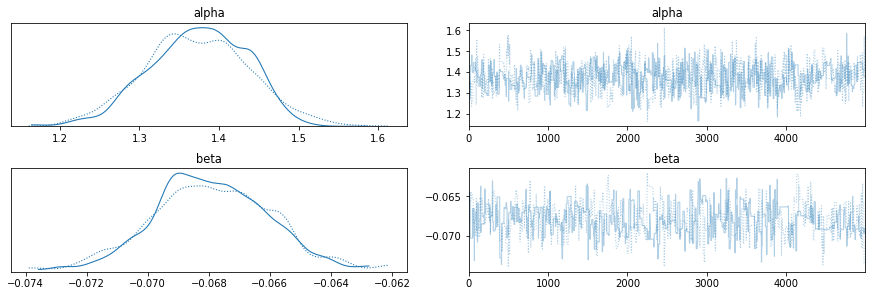

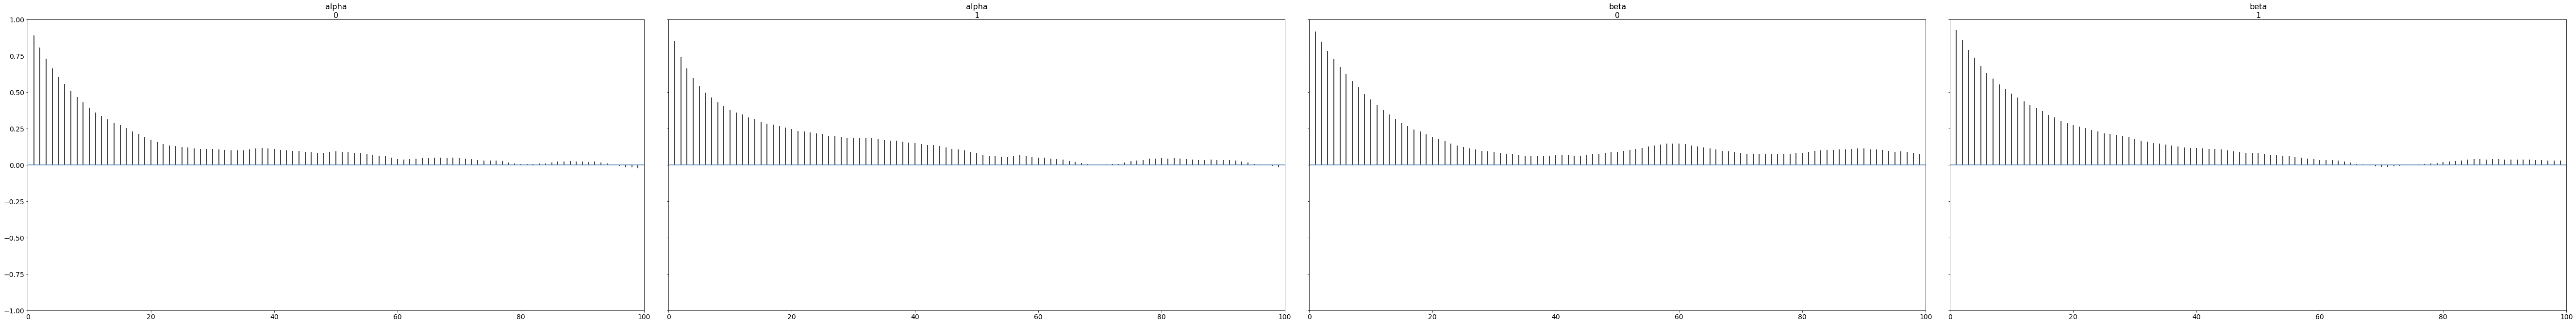

In [34]:
pm.traceplot(sleep_trace, ['alpha', 'beta'])
pm.autocorrplot(sleep_trace, ['alpha', 'beta'])

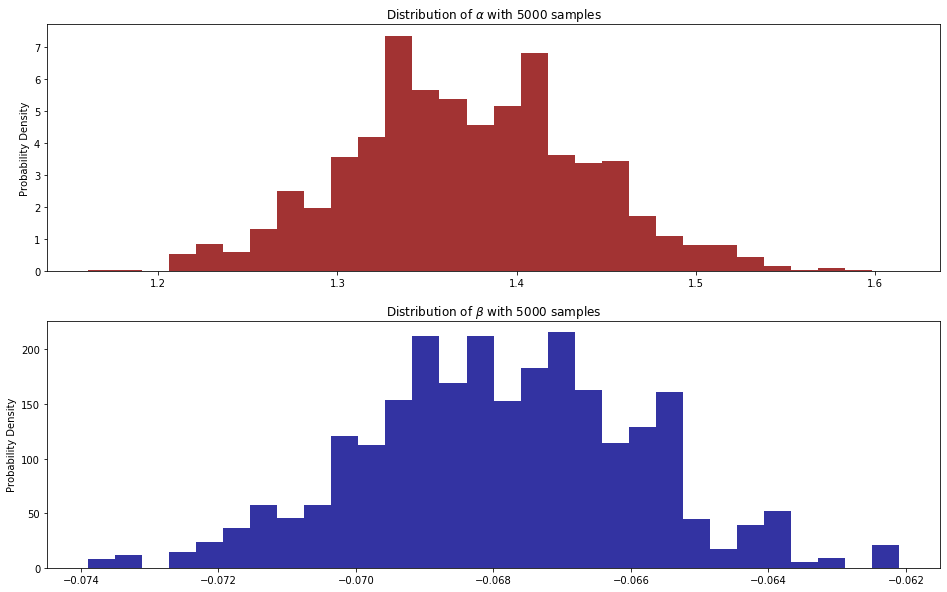

In [12]:
figsize(16, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

If the $\beta$ values were centered around 0 that would indicate time has no effect on the probability of being asleep. The $\alpha$ values also are not at 0, indicating that there is an offset from 10:00 pm in terms of being asleep. I choose to represent the times as an offset from 10:00 PM to avoid dealing with data times as much as possible.

The spread of the data gives us a measure of uncertainty about the data. A larger spread indicates more uncertainty. As there is considerable overlap in the observations for awake and asleep, the uncertainty is expected to be large. To find the most likely posterior distribution for sleep given the time, we take the average of the $\alpha$ and $\beta$ samples.

#### Posterior for Sleep Visualization

In [21]:
#logistic probability
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

In [22]:
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1000)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

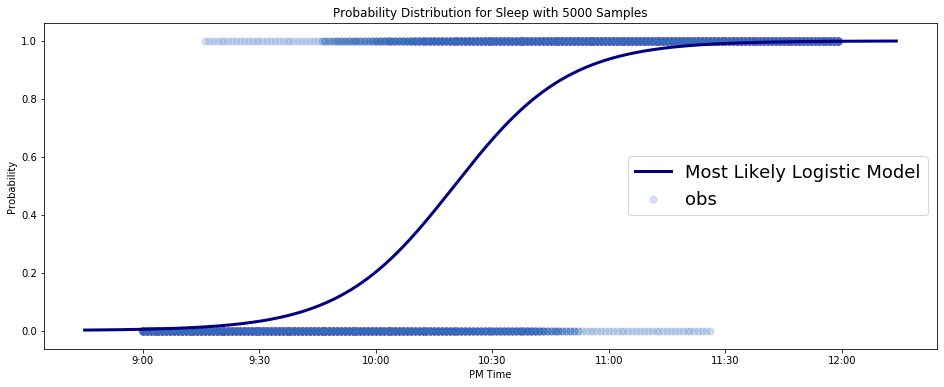

In [23]:

figsize(16, 6)
#model from MCMC sleep_est
plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="Most Likely Logistic Model")
plt.scatter(time, sleep_obs, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title('Probability Distribution for Sleep with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('Probability')
plt.xlabel('PM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);


The posterior probability increases from 0 to 1 as the time gets later. The model is not perfect because of the noise in the data, but it is an adequate approximation based on the observations and can provide useful estimates.

In [24]:
print('The probability of sleep increases to above 50% at 10:{} PM.'.format(int(time_est[np.where(sleep_est > 0.5)[0][0]][0])))

The probability of sleep increases to above 50% at 10:20 PM.


In [25]:
print('The probability of sleep increases to above 80% at 10:{} PM.'.format(int(time_est[np.where(sleep_est > 0.8)[0][0]][0])))

The probability of sleep increases to above 80% at 10:40 PM.


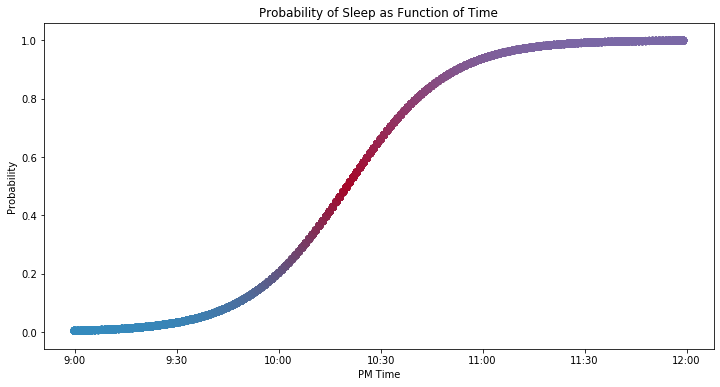

In [26]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = sleep_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Sleep as Function of Time')
plt.xlabel('PM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

The posterior can be queried at any time (as an offset from 10:00 PM) to find the probability I am asleep.

In [27]:
print('10:00 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(0, beta_est, alpha_est)))
print('9:30  PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(-30, beta_est, alpha_est)))
print('10:30 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(30, beta_est, alpha_est)))

10:00 PM probability of being asleep: 20.23%.
9:30  PM probability of being asleep: 3.20%.
10:30 PM probability of being asleep: 66.03%.


##### Confidence Interval
There are many other diagnostics of the model that we can perform. For example, we know there is a considerable amount of uncertainty in our estimates for $\alpha$ and $\beta$. To reflect this in the graph, we can include include the 95% confidence interval at each time based on all of the samples.

In [28]:
sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = stats.mstats.mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

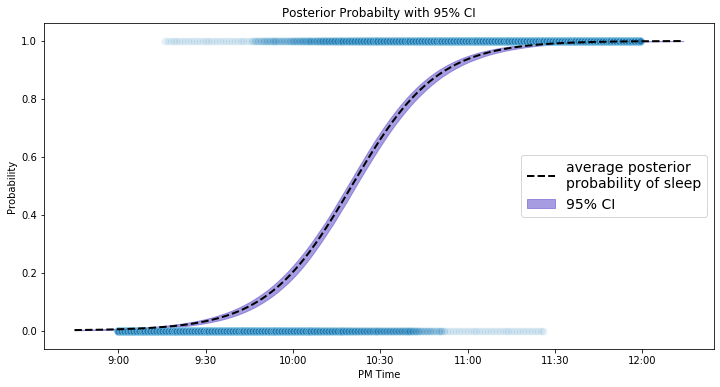

In [29]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, 
                 color='slateblue', label = '95% CI')
plt.plot(time_est, sleep_est, lw=2, ls='--', 
         color='black', label="average posterior \nprobability of sleep")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('PM Time'); plt.ylabel('Probability'); 
plt.title('Posterior Probabilty with 95% CI');

At each time, there is a measure of uncertainty as to whether or not I am asleep. This represents the fact that MCMC does not return the True parameters.

### Posterior Probability Distribution for Specific Time
We can also plot the posterior distribution of sleep at a time as a histogram based on all of the samples for the paramters. This gives us another look at the uncertainty in the model.

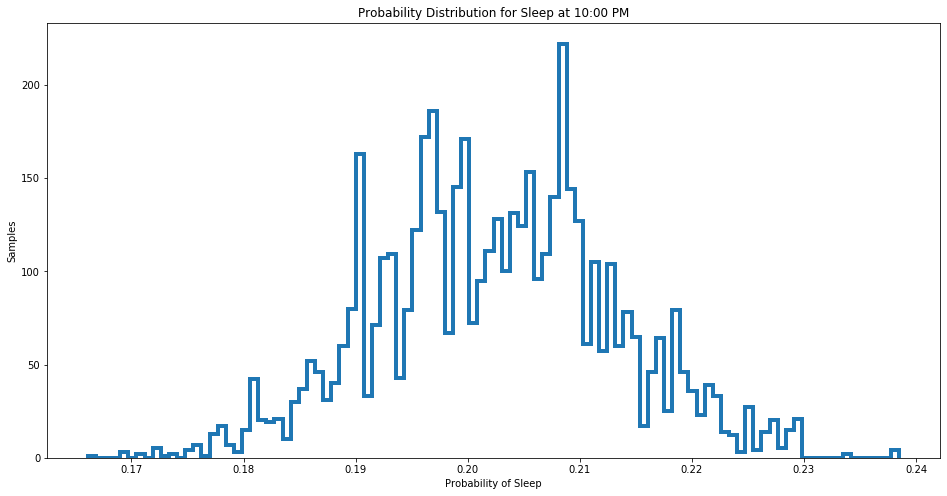

In [30]:
def sleep_posterior(time_offset, time):
    figsize(16, 8)
    prob = logistic(time_offset, beta_samples, alpha_samples)
    plt.hist(prob, bins=100, histtype='step', lw=4)
    plt.title('Probability Distribution for Sleep at %s PM' % time)
    plt.xlabel('Probability of Sleep'); plt.ylabel('Samples')
    plt.show();


sleep_posterior(0, '10:00')

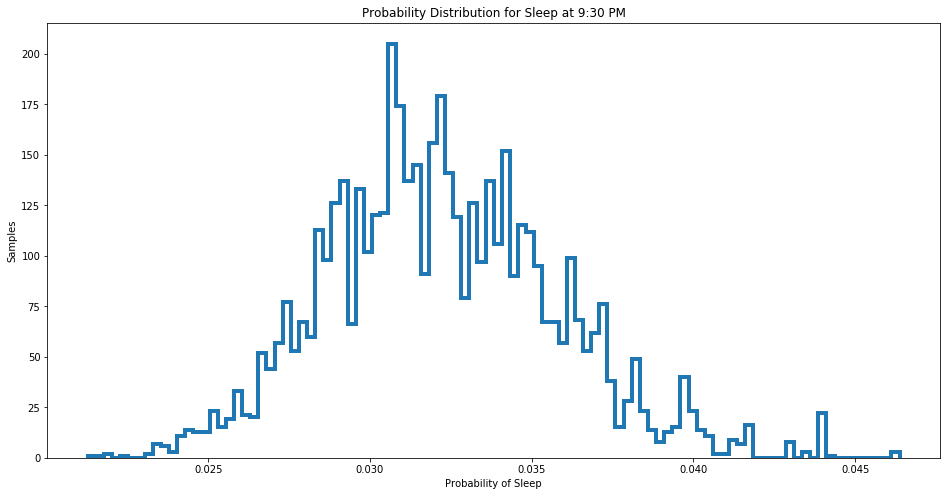

In [31]:
sleep_posterior(-30, '9:30')

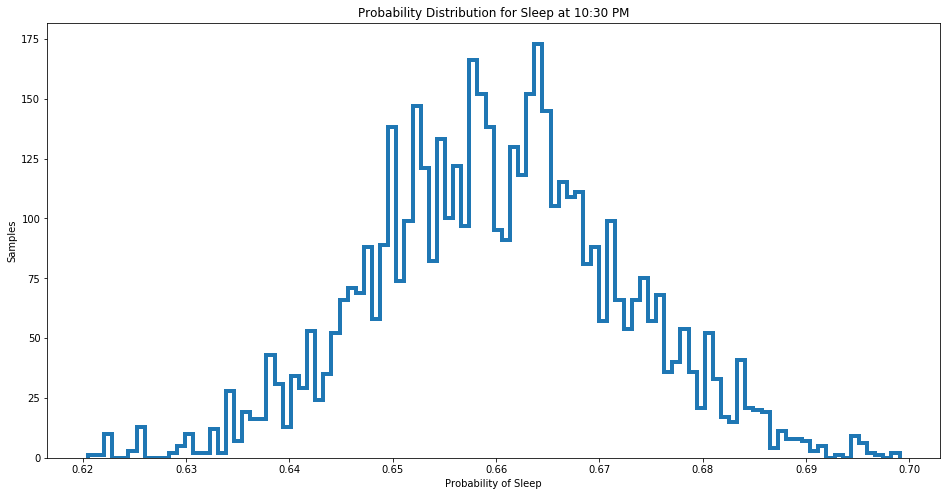

In [32]:
sleep_posterior(30, '10:30')

In [33]:
print('Most likely alpha parameter: {:.6f}.'.format(alpha_est))
print('Most likely beta  parameter: {:.6f}.'.format(beta_est))

Most likely alpha parameter: 1.371903.
Most likely beta  parameter: -0.067888.


#### Convergence in Markov Chain Monte Carlo
How can we know if the model converged? We can look at the trace, or the path of the values over sampling. Another option is to look at the auto-correlation of the samples. In Markov Chain modeling, the samples are correlated with themselves because the next value depends on the current state (or the current state and past states based on the order). Initially, the algorithm tends to wander about the search space and will have a high auto-correlation. As the algorithm converges, the samples will settle down around a value and one measure of convergence is a low auto-correlation. We will not do a rigorous study of convergence in this report, but we can plot the traces of all the samples.

#### Trace Plots
The plots below show all the samples of $\alpha$ and $\beta$ from the algorithm.

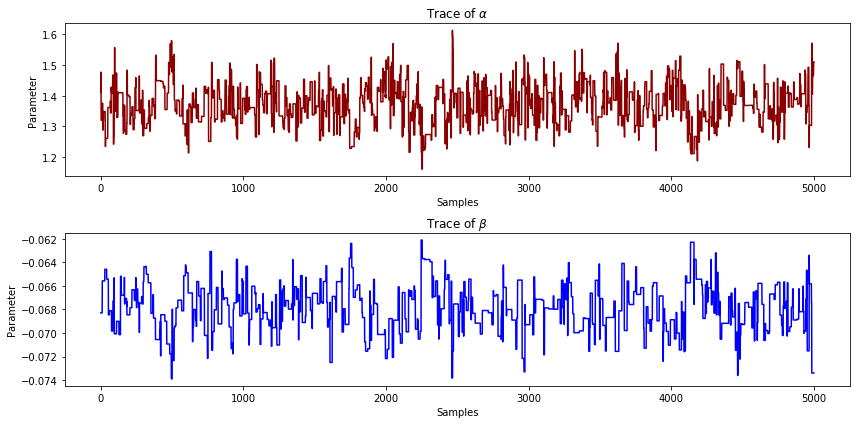

In [35]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

Built in Diagnostics
PyMC3 has many built-in diagnostics for model evaluation. Here are the trace plot and autocorrelation plots.

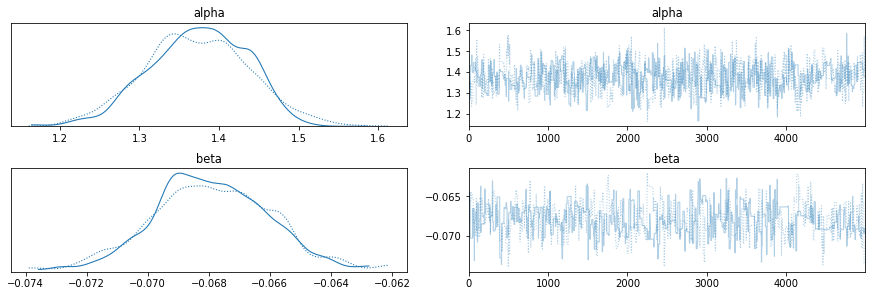

In [36]:
figsize(20, 12)
pm.traceplot(sleep_trace, ['alpha', 'beta']);

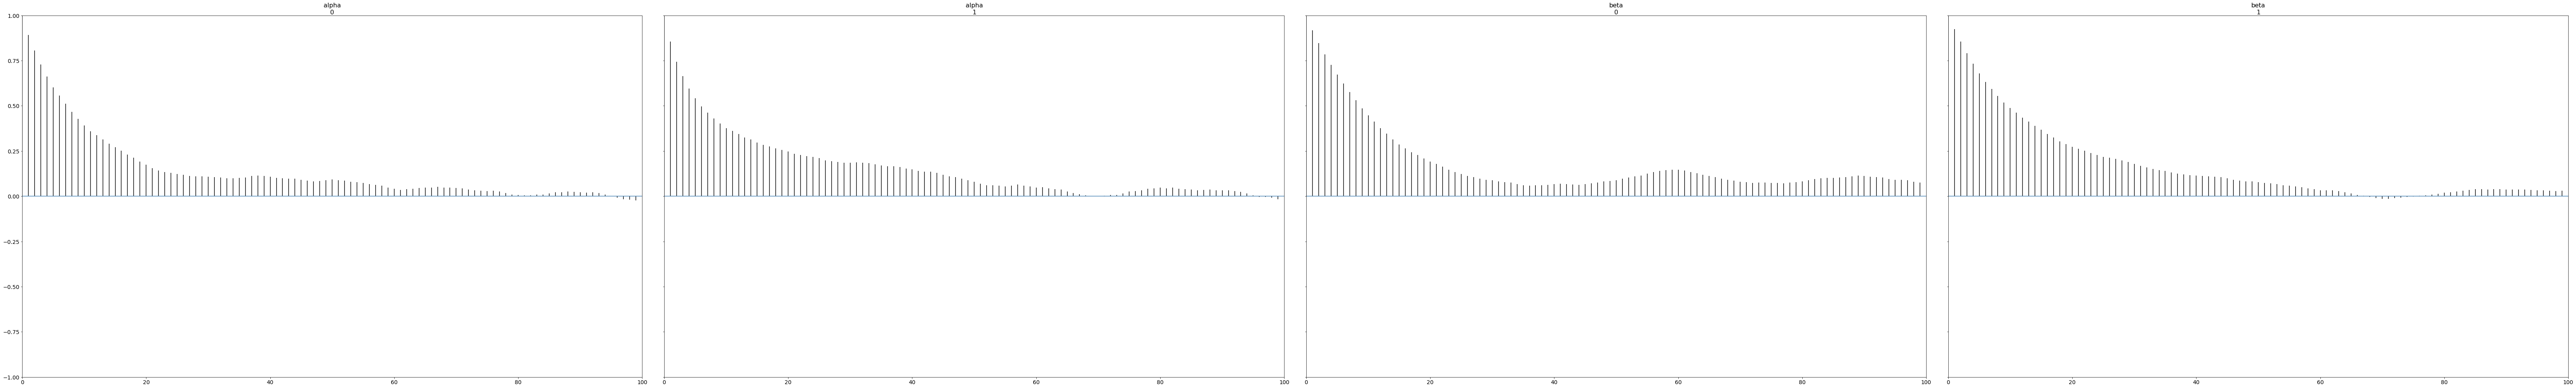

In [37]:
pm.autocorrplot(sleep_trace, ['alpha', 'beta']);

Conclusions
Based on the observations, we can state the following:

On average I fall asleep by 10:14 PM
On average I wake up by 6:11 AM

The models have already provided with knowledge about sleeping patterns, and more data would only improve the applicability. I could incorporate additional information such as day of the week or daily activities to see how they affect my sleep and then make adjustments as required. Although this report made several assumptions and did not fully investigate the models, it was a great start towards analyzing actual data with Bayesian methods. 